In [263]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
    
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
      
    def get_csv_path(self):
      return self.root_folder + "/textual_notes/CSVs/" + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/models/" + self.save_filename
      
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 0
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_path(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/' + self.save_filename
    
    def get_models_path(self):
      return self.root_folder + "/gdrive/My Drive/DL/models/" + self.save_filename
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [264]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [265]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [266]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [267]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [268]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [269]:
batch_size = 8
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [270]:
model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet
model_name = model.__name__
z_dim = 10

class SoftmaxWrapper(nn.Module):
  def __init__(self, m):
    super().__init__()
    self.m = m
    self.softmax = nn.Softmax(dim=-1)
    
  def forward(self, inp):
    out = self.m(inp)
    return self.softmax(out)
  
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

# resnet:
# layers = [
#   arch.layer2[0].downsample,
#   arch.layer3[0].downsample,
#   arch.layer4[0].downsample
# ]
layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# layers = []
# last_layer = None
# for o in children(arch):
#   if isinstance(o, nn.AdaptiveAvgPool2d):
#     layers.append(last_layer)
#   last_layer = o
    
# # layers = [arch.fc]

# layer_weights = [1] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [271]:
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, 
                             self.gf_dim * 4,
                              k_size = (5,5), s = (2,2), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)

    self.half = self.gf_dim // 2
    if self.half == 0:
      self.half == 1
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)

    self.quarter = self.gf_dim // 4
    if self.quarter == 0:
      self.quarter == 1
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)

    self.eighth = self.gf_dim // 8
    if self.eighth == 0:
      self.eighth == 1
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = self.gf_dim // 16
    # if half == 0:
      # half == 1
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)

    # sixteenth = self.gf_dim // 16
    # if half == 0:
      # half == 1
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)


  def forward_z(self, z):
    self.bs = z.shape[0]
      
    # define generator here
    # input: bs * 100
    # Linear (z_dim, gf_dim * 7 * 4 * 4), bias = (True, init with zero), 
    # Reshape (bs, gf_dim * 7 * 4 * 4) -> (bs, gf_dim * 7, 4 , 4)
    # Virtual Batch Norm = VBN
    # ReLU
    # h0 <- relu output
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    # h0z = self.make_z([bs, gf_dim, 4, 4])
    # h0 = torch.cat([h0, h0z], dim=1)
    # h1 = deconv(gf_dim * 8, gf_dim * 4, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h1 = ReLU(VBN(h1))
    h0z = self.make_z([self.bs, self.gf_dim, 4, 4])
    h0 = torch.cat([h0, h0z], dim=1)
    h1 = self.CT2d_1(h0)
    assert h1.shape[2:] == (7, 7), "Non-expected shape, it shoud be (7,7)"

    # h1z = self.make_z([bs, gf_dim, 7, 7])
    # h1 = torch.cat([h1, h1z], dim=1)
    # h2 = deconv(gf_dim * 5, gf_dim * 2, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h2 = ReLU(VBN(h2))
    # assert output size (14,14)
    h1z = self.make_z([self.bs, self.gf_dim, 7, 7])
    h1 = torch.cat([h1, h1z], dim=1)
    h2 = self.CT2d_2(h1)
    assert h2.shape[2:] == (14,14), "Non-expected shape, it shoud be (14,14)"

    # h2z = self.make_z([bs, half, 14, 14])
    # h2 = torch.cat([h2, h2z], dim=1)
    # h3 = deconv(gf_dim  2 + half, gf_dim  1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h3 = ReLU(VBN(h3))
    h2z = self.make_z([self.bs, self.half, 14, 14])
    h2 = torch.cat([h2, h2z], dim=1)
    h3 = self.CT2d_3(h2)
    assert h3.shape[2:] == (28,28), "Non-expected shape, it shoud be (28,28)"

    # h3z = self.make_z([bs, quarter, 28, 28])
    # h3 = torch.cat([h3, h3z], dim=1)
    # h4 = deconv(gf_dim * 1 + quarter, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h4 = ReLU(VBN(h4))
    h3z = self.make_z([self.bs, self.quarter, 28, 28])
    h3 = torch.cat([h3, h3z], dim=1)
    h4 = self.CT2d_4(h3)
    assert h4.shape[2:] == (56,56), "Non-expected shape, it shoud be (56,56)"

    # h4z = self.make_z([bs, self.eighth, 56, 56])
    # h4 = torch.cat([h4, h4z], dim=1)
    # h5 = deconv(gf_dim * 1 + eighth, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h5 = ReLU(VBN(h5))

    h4z = self.make_z([self.bs, self.eighth, 56, 56])
    h4 = torch.cat([h4, h4z], dim=1)
    h5 = self.CT2d_5(h4)
    assert h5.shape[2:] == (112,112), "Non-expected shape, it shoud be (112,112)"

    # h5z = self.make_z([bs, eighth, 112, 112])
    # h5 = torch.cat([h5, h5z], dim=1)
    # h6 = deconv(gf_dim * 1 + eighth, gf_dim * 1, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h6 = ReLU(VBN(h5))
    h5z = self.make_z([self.bs, self.eighth, 112, 112])
    h5 = torch.cat([h5, h5z], dim=1)
    h6 = self.CT2d_6(h5)
    assert h6.shape[2:] == (224,224), "Non-expected shape, it shoud be (224,224)"

    # h6z = self.make_z([bs, eighth, 224, 224])
    # h6 = torch.cat([h6, h6z], dim=1)
    # h7 = deconv(gf_dim * 1 + eighth, 3, kernel = (5, 5), stride = (2,2), padding = (2,2), bias = (True, 0))
    # h7 = ReLU(VBN(h7))
    h6z = self.make_z([self.bs, self.eighth, 224, 224])
    h6 = torch.cat([h6, h6z], dim=1)
    h7 = self.CT2d_7(h6)
    assert h7.shape[2:] == (224,224), "Non-expected shape, it shoud be (448,448)"

    # out = 10*tanh(h7)

    #     return 10 *F.tanh(h7)
    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)
    # return 0.15 * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     negative_sample = z + self.random_vector_volume(z.shape, margin, margin * scale).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

#   def random_vector_volume(shape, inner_r = 0, outer_r):
#     d = torch.zeros(shape[0]).uniform_()   ** (1/int(np.prod(shape[0])))
#     d.unsqueeze_(-1)
#     return random_vector_surface(shape, outer_r) * d
  
  def random_vector_volume(self, shape, inner_r, outer_r):
#     d = torch.zeros(shape[0]).uniform_(0, outer_r - inner_r).cuda()
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * d + inner_r
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)


In [272]:
torch.set_printoptions(precision=2, sci_mode=False, threshold=5000)

def print_softmax_tensor(x):
  print("[", end="")
  for i, x_i in enumerate(x.data):
    if abs(x_i) > 0.01:
      print("{}: {:.2f}".format(i, x_i.item()), end=(", " if (i < x.shape[0]-1) else ""))
  print("]")

In [353]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
#   print(x1)
#   print(x2)
  return torch.norm(x1 - x2, 2)
#   return torch.sum((x1 - x2) ** 2) ** (0.5)

def distance_from_uniform(x):
  

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def cos_distance(x1, x2):
    return -1 * torch.mean(F.cosine_similarity(x1, x2))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 == 0 and anchor.shape[1] == 1000:
    print("a: ", end=""); print_softmax_tensor(anchor[0])
    print("p: ", end=""); print_softmax_tensor(positive[0])
    print("n: ", end=""); print_softmax_tensor(negative[0])
    print("ap_dist: {}, an_dist: {}".format(ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [274]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

In [275]:
# z1 = torch.tensor([[1., 0.]])
# z2 = torch.tensor([[-1., 0]])
# cos_sim(z1,z2)

# z1 = torch.tensor([[0.5, 0.5]])
# z2 = torch.tensor([[0.55, 0.45]])
# F.kl_div(z1, z2, reduction='batchmean')

In [276]:
def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  print("img range: ")
  print_range(clean_images)
  print("noise range:")
  print_range(perturbations)
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)

  return (benign_preds != adversary_preds).float().mean()

In [277]:
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] #+ ['triplet_loss_1', 'triplet_loss_2']# Maybe Gram
        self.triplet_weight_noise = 5.
        self.triplet_weight_sm = 5.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
#         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
#         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))

#         return sum(self.losses)

#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

    # just fooling and diversity
    def forward(self, inp, target):
      sigma_B, sigma_pos, sigma_neg, X_B = inp

      X_A = self.add_perturbation(X_B, sigma_B) 

      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      fooling_loss =  fool_loss(A_Y, B_Y)

      raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
      weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

      self.losses = [fooling_loss] + weighted_diversity_losses
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
#         j = torch.randperm(inp.shape[0])
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [278]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [279]:
env.save_filename = 'resnet152_3'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [280]:
learn = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [281]:
# learn.lr_find(1e-6, 1000)
# learn.recorder.plot()

In [282]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# learn.load('/root/Derakhshani/adversarial/models/vgg16_11/vgg16_11_29')
# learn.load('/root/Derakhshani/adversarial/models/vgg16_12-last')
# learn.load('/root/Derakhshani/adversarial/models/resnet50-11_39')

In [ ]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")
if len(learn.callback_fns) == 1:
  print("\n\n\nWARNING: you are not using the DiversityWeightsScheduler callback.\n\n\n")

    
saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# import cProfile

# pr = cProfile.Profile()
# pr.enable()
learn.fit(50, lr=8e-02, wd = 0., callbacks=[saver_best, saver_every_epoch])
# pr.disable()

# learn.fit_one_cycle(8, max_lr=5e-01) #mohammad's setting that got 77 validation start on resnet with diversity loss on AdaptiveAvgPool2d
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())

# pr.print_stats()

# shutil.copyfile("/content/dataset/models/" + save_filename + "-best.pth", "/content/gdrive/My Drive/DL/models/" + save_filename + ".pth")

epoch,train_loss,valid_loss,validation,fool_loss,div_loss_0,time
0,1.908522,1.876815,0.336000,0.876817,0.999999,07:38
1,1.879509,1.861990,0.341000,0.862003,0.999987,07:37
2,1.824444,1.844112,0.346000,0.844115,0.999998,07:33
3,1.816546,1.844789,0.346000,0.844792,0.999998,07:37
4,1.796058,1.815193,0.357000,0.815218,0.999976,07:33
5,1.788141,1.801140,0.372000,0.801164,0.999977,07:34
6,1.803424,1.790186,0.378000,0.790207,0.999980,07:34
7,1.723847,1.784932,0.374000,0.784961,0.999971,07:31
8,1.797076,1.788025,0.375000,0.788060,0.999966,07:37
9,1.727162,1.769533,0.378000,0.769561,0.999972,07:35


img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.6399242877960205
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.11738657951355 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1178901195526123 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.173

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.11782169342041 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.1735207

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.115190267562866 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1174213886260986 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.173

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
Better model found at epoch 1 with validation value: 0.3409999907016754.
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.117

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.6398427486419678
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.1735207

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1166913509368896 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.116039276123047 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1177399158477783 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1166913509368896 2.640000104904175
noise range:
-0.17352072894573212 0.

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1173548698425293 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1176719665527344 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.116039276123047 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.173

img range: 
-2.1179039478302 2.6399242877960205
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.11738657951355 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1178901195526123 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.173

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.11782169342041 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.1735207

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.115190267562866 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1174213886260986 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.173

img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
img range: 
-2.1179039478302 2.640000104904175
noise range:
-0.17352072894573212 0.17352072894573212
Better model found at epoch 12 with validation value: 0.3919999897480011.


In [ ]:
!cp "/content/gdrive/My Drive/DL/models/resnet50-dir/resnet50-dir-best.pth" "/content/resnet50-best.pth"
learn.load("/content/resnet50-best")

In [ ]:
learn.fit(1, lr = 0., wd=0.)

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [202]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations
  
  
# def compute_mean_prediction_histogram(learn, perturbations):
#   pred_histogram = [0] * 1000
#   for j, perturbation in enumerate(perturbations):
#     for i in range(len(learn.data.valid_ds)):
#       img = learn.data.valid_ds[i][0].data[None].cuda()
#       perturbed_img = img + perturbation
#       pred = torch.argmax(arch(perturbed_img).squeeze())
#       pred_histogram[pred]+= 1./len(perturbations)
#     print("finished creating histogram for the %dth perturbation"%j)
#   return pred_histogram

  
def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = [0] * 1000
  for j, perturbation in enumerate(perturbations):
    batch_no = -1
    for batch, _ in learn.data.valid_dl:
      batch_no += 1
      if batch_no % 100 == 0 : print("at batch no {}".format(batch_no))
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_histogram[pred]+= 1.
    print("finished creating histogram for the %dth perturbation"%j)
  
  pred_histogram = np.asarray(np.array(pred_histogram) / len(perturbations))
  
  return pred_histogram

def diversity(learn, n_perturbations, percentage):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  #top_classes is a useful piece of info that is currently unused
  return n_used_classes, indexed_pred_histogram, top_classes

In [238]:
def entropy(x):
  if not isinstance(x, torch.Tensor):
    x = torch.tensor(x)
  x = x / torch.sum(x)
  epsilon = 1e-10
  return - torch.sum(x * (torch.log(x + epsilon) / torch.log(torch.tensor(2.))))

In [203]:
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100
finished creating histogram for the 0th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 1th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 2th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 3th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 4th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 5th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 6th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 7th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 8th perturbation
at batch no 0
at batch no 100
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(240,
 [(858, 159.2),
  (794, 75.6),
  (259, 56.5),
  (260, 56.4),
  (373, 54.7),
  (187, 45.0),
  (230, 33.0),
  (192, 30.6),
  (380, 28.2),
  (368, 21.5),
  (201, 19.9),
  (355, 18.3),
  (193, 17.3),
  (283, 16.8),
  (365, 16.1),
  (186, 8.7),
  (387, 8.3),
  (226, 6.8),
  (721, 6.3),
  (203, 6.2),
  (231, 5.6),
  (336, 5.0),
  (443, 3.8),
  (646, 3.8),
  (591, 3.7),
  (372, 3.6),
  (658, 3.4),
  (182, 3.2),
  (109, 3.1),
  (381, 3.0),
  (255, 2.8),
  (697, 2.8),
  (202, 2.7),
  (378, 2.7),
  (184, 2.6),
  (411, 2.6),
  (489, 2.6),
  (271, 2.5),
  (274, 2.5),
  (716, 2.5),
  (703, 2.4),
  (382, 2.3),
  (342, 2.2),
  (879, 2.2),
  (261, 2.1),
  (292, 2.1),
  (374, 2.1),
  (79, 2.0),
  (189, 2.0),
  (84, 1.9),
  (155, 1.9),
  (309, 1.9),
  (384, 1.9),
  (284, 1.7),
  (735, 1.7),
  (800, 1.7),
  (854, 1.7),
  (953, 1.7),
  (76, 1.6),
  (334, 1.6),
  (347, 1.6),
  (533, 1.6),
  (580, 1.6),
  (738, 1.6),
  (815, 1.6),
  (850, 1.6),
  (865, 1.6),
  (375, 1.5),
  (506, 1.5),
  (509, 1.5),
 

In [298]:
hist.sort(key=lambda x: x[0], reverse = False)

In [292]:
values = [elem[1] for elem in hist]

In [293]:
entropy(values)
# entropy([10.] * 1000)

tensor(6.44)

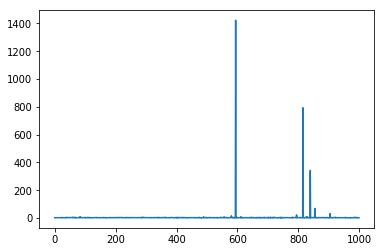

In [294]:
import matplotlib.pyplot as plt
plt.plot(values)

In [354]:
uniform = [1.] * 1000
x = [1.] + [0.] * 999
distrib_distance(uniform, x)

tensor(99.95)

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

[414: 0.01, 464: 0.02, 530: 0.01, 546: 0.02, 556: 0.09, 636: 0.05, 688: 0.05, 748: 0.02, 753: 0.01, 754: 0.02, 794: 0.08, 819: 0.02, 854: 0.31, 868: 0.01, ]
[777: 1.00, ]
(777, 'scabbard') (854, 'theater curtain, theatre curtain')


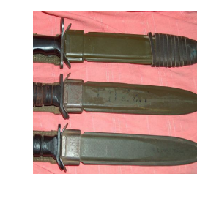

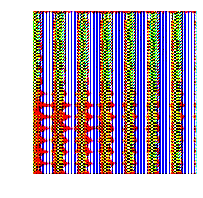

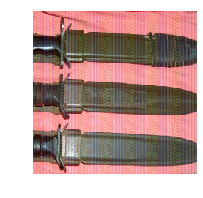

In [165]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[500][0]
x = normalize(x_img.data.cuda())
# z = torch.tensor([-1, 0.5, -1, 1, 1, -1, -1, -1, -1, 1], dtype=torch.float32).cuda()
z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_softmax_tensor(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_softmax_tensor(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)